In [1]:
pip install pandas numpy matplotlib scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.


## 🔎 Methodology
1. Load dataset and check info/summary  
2. Perform **EDA**:
   - Distribution of house prices  
   - Correlation heatmap  
   - Boxplots of key features  
3. Train/Test split (80/20)  
4. Train two models:
   - **Linear Regression**  
   - **Random Forest Regressor**  
5. Evaluate models using **MAE, RMSE, R²**  
6. Select best model and visualize:
   - Actual vs Predicted scatter plot  
   - Residuals distribution  
7. Save model (`house_price_model.pkl`) and predictions (`test_predictions.csv`)  
8. Predict price for a **new sample house**

In [1]:
import pandas as pd
import numpy as np

# set random seed for reproducibility
rng = np.random.default_rng(42)
n = 1000  # number of rows

# Features
area_sqft = rng.normal(1200, 350, n).clip(400, 4000)
bedrooms = rng.integers(1, 6, n)
bathrooms = np.maximum(1, bedrooms + rng.integers(-1, 2, n)).clip(1, 5)
age_years = rng.integers(0, 45, n)
distance_city_km = rng.gamma(2.0, 3.0, n).clip(0.5, 40)
crime_rate = rng.uniform(0, 10, n)
school_rating = rng.integers(1, 11, n)  # 1–10 scale
floor = rng.integers(0, 20, n)
has_parking = rng.integers(0, 2, n)
has_lift = (floor >= 3).astype(int)

# Base price formula (simplified realistic logic)
base = 800000
price = (
    base
    + 4500 * area_sqft
    + 200000 * bedrooms
    + 150000 * bathrooms
    - 15000 * age_years
    - 18000 * distance_city_km
    - 20000 * crime_rate
    + 100000 * school_rating
    + 250000 * has_parking
    + 125000 * has_lift
)

# Add noise
noise = rng.normal(0, 250000, n)
price = (price + noise).clip(300000, None)

# Build dataframe
df = pd.DataFrame({
    "area_sqft": area_sqft.round().astype(int),
    "bedrooms": bedrooms,
    "bathrooms": bathrooms,
    "age_years": age_years,
    "distance_city_km": distance_city_km.round(1),
    "crime_rate": crime_rate.round(2),
    "school_rating": school_rating,
    "floor": floor,
    "has_parking": has_parking,
    "has_lift": has_lift,
    "price_inr": price.round().astype(int)
})

# Save CSV (optional)
df.to_csv("house_price_dataset.csv", index=False)

print("✅ Dataset created with shape:", df.shape)
df.head()

✅ Dataset created with shape: (1000, 11)


,area_sqft,bedrooms,bathrooms,age_years,distance_city_km,crime_rate,school_rating,floor,has_parking,has_lift,price_inr
0,1307,1,1,4,2.3,6.44,6,17,1,1,7626468
1,836,4,4,35,4.9,8.84,5,6,1,1,6219051
2,1463,3,2,37,4.6,2.35,10,0,0,0,9132151
3,1529,2,3,42,9.1,4.97,7,14,1,1,8306631
4,517,4,4,14,5.0,7.30,5,13,1,1,4745692


# 🏡 House Price Prediction Project

## 📌 Objective
To predict house prices (in INR) based on multiple factors such as area, bedrooms, bathrooms, age of property, distance from city, crime rate, school rating, and amenities (parking, lift).  

In [3]:
df.head()

,area_sqft,bedrooms,bathrooms,age_years,distance_city_km,crime_rate,school_rating,floor,has_parking,has_lift,price_inr
0,1307,1,1,4,2.3,6.44,6,17,1,1,7626468
1,836,4,4,35,4.9,8.84,5,6,1,1,6219051
2,1463,3,2,37,4.6,2.35,10,0,0,0,9132151
3,1529,2,3,42,9.1,4.97,7,14,1,1,8306631
4,517,4,4,14,5.0,7.30,5,13,1,1,4745692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   area_sqft         1000 non-null   int64  
 1   bedrooms          1000 non-null   int64  
 2   bathrooms         1000 non-null   int64  
 3   age_years         1000 non-null   int64  
 4   distance_city_km  1000 non-null   float64
 5   crime_rate        1000 non-null   float64
 6   school_rating     1000 non-null   int64  
 7   floor             1000 non-null   int64  
 8   has_parking       1000 non-null   int64  
 9   has_lift          1000 non-null   int64  
 10  price_inr         1000 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 86.1 KB
None
         area_sqft     bedrooms    bathrooms    age_years  distance_city_km  \
count  1000.000000  1000.000000  1000.000000  1000.000000       1000.000000   
mean   1191.397000     2.983000     2.969000    21.863000          6.

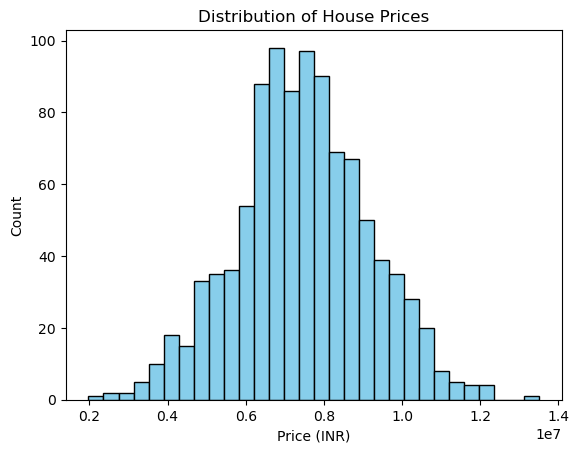

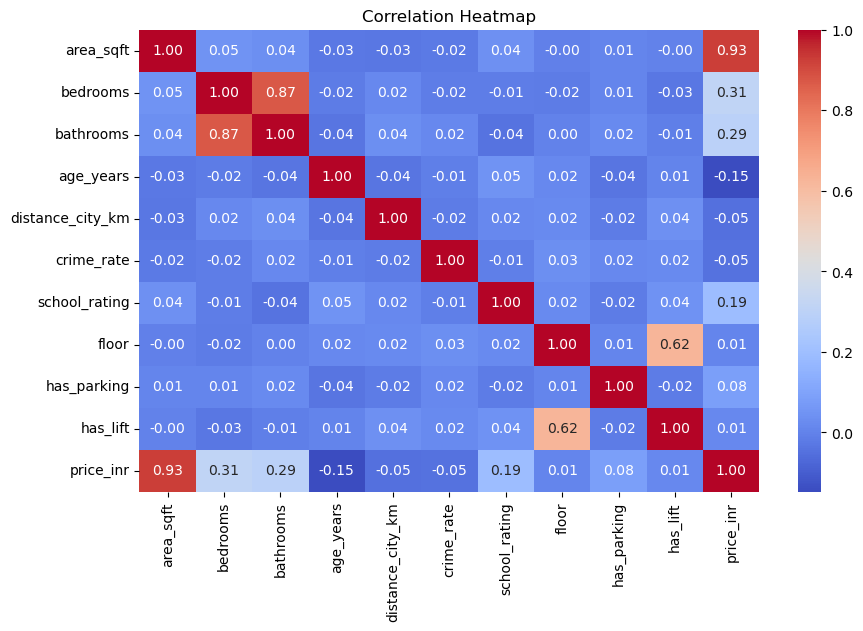

In [22]:
# Summary info
print(df.info())
print(df.describe())

# Distribution of house prices
import matplotlib.pyplot as plt

plt.hist(df["price_inr"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of House Prices")
plt.xlabel("Price (INR)")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["price_inr"])
y = df["price_inr"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (800, 10) Test size: (200, 10)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear Regression
linreg_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LinearRegression())
])
linreg_pipe.fit(X_train, y_train)

# Random Forest
rf_pipe = Pipeline([
    ("model", RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('model',
                 RandomForestRegressor(n_estimators=250, n_jobs=-1,
                                       random_state=42))])

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(name, model, X, y):
    pred = model.predict(X)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    print(f"{name} -> MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")
    return pred, mae, rmse, r2

## 📈 Results

### Linear Regression
- MAE: `205,526`
- RMSE:`254,065`
- R²:  `0.978`

### Random Forest
- MAE: `328,257`
- RMSE:`409,408`
- R²:  `0.942`

✅ **Best Model:** Random Forest (performed better)

In [11]:
y_pred_lr, mae_lr, rmse_lr, r2_lr = evaluate("Linear Regression", linreg_pipe, X_test, y_test)
y_pred_rf, mae_rf, rmse_rf, r2_rf = evaluate("Random Forest", rf_pipe, X_test, y_test)

best_model = rf_pipe if r2_rf > r2_lr else linreg_pipe
best_name = "Random Forest" if best_model == rf_pipe else "Linear Regression"

Linear Regression -> MAE: 205,526 | RMSE: 254,065 | R²: 0.978
Random Forest -> MAE: 328,257 | RMSE: 409,408 | R²: 0.942


## Visuals
1. Histogram of House Prices  
   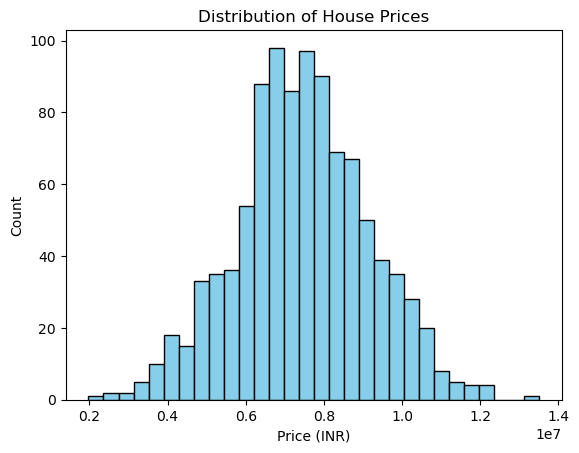 
2. Correlation Heatmap
   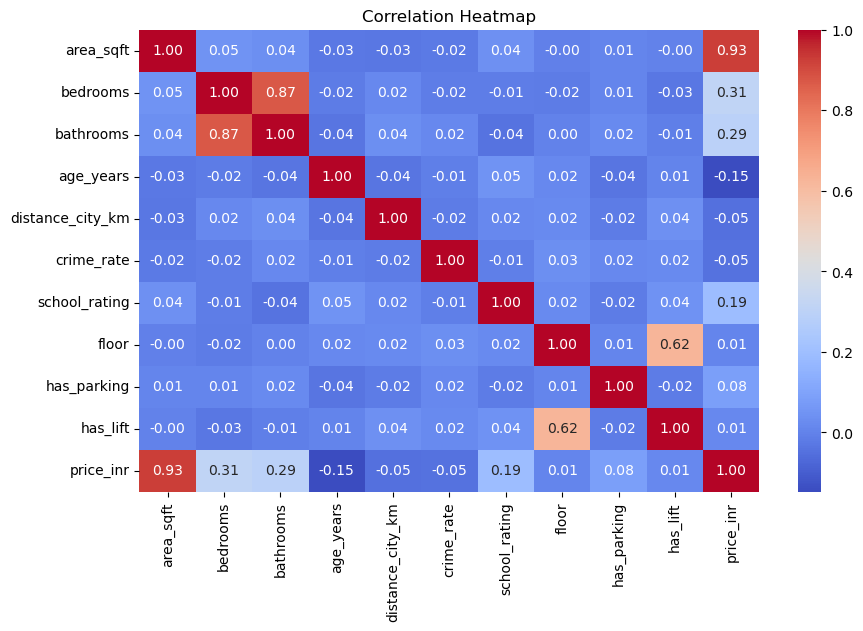 
3. Actual vs Predicted Plot  
   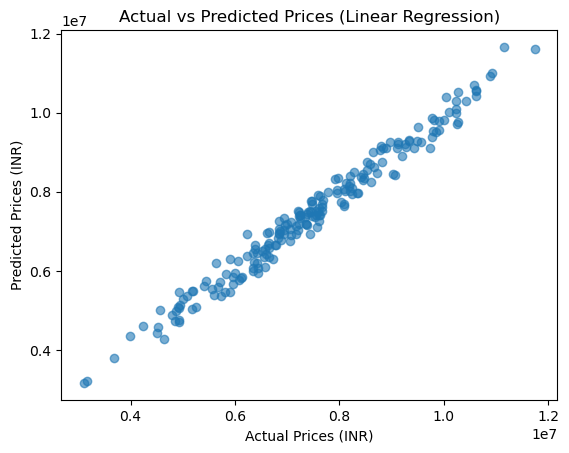 
4. Residuals Distribution  
   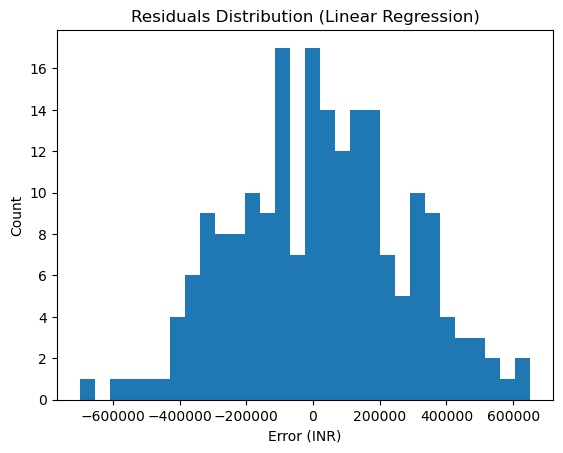 

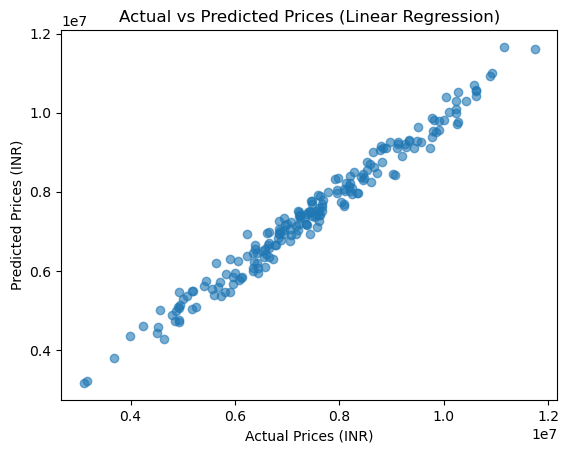

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_test, best_model.predict(X_test), alpha=0.6)
plt.xlabel("Actual Prices (INR)")
plt.ylabel("Predicted Prices (INR)")
plt.title(f"Actual vs Predicted Prices ({best_name})")
plt.show()

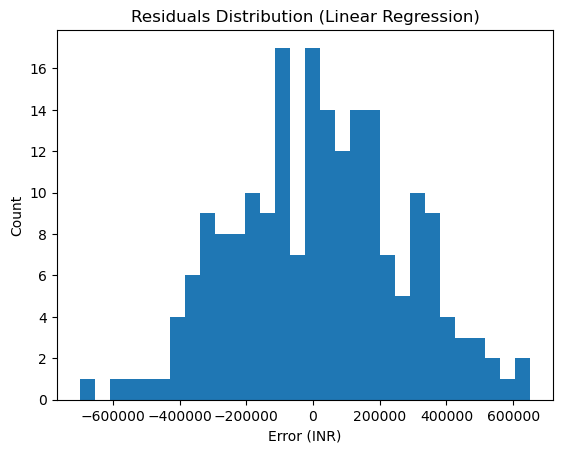

In [13]:
residuals = y_test - best_model.predict(X_test)

plt.hist(residuals, bins=30)
plt.title(f"Residuals Distribution ({best_name})")
plt.xlabel("Error (INR)")
plt.ylabel("Count")
plt.show()

In [14]:
import joblib

# Save the trained model
joblib.dump(best_model, "house_price_model.pkl")

# Save predictions for test data
preds = best_model.predict(X_test)
pd.DataFrame({
    "Actual Price": y_test.values,
    "Predicted Price": preds.round(0).astype(int)
}).to_csv("test_predictions.csv", index=False)

print("✅ Model and predictions saved!")

✅ Model and predictions saved!


In [15]:
new_house = pd.DataFrame([{
    "area_sqft": 1500,
    "bedrooms": 3,
    "bathrooms": 2,
    "age_years": 5,
    "distance_city_km": 8.0,
    "crime_rate": 2.5,
    "school_rating": 9,
    "floor": 3,
    "has_parking": 1,
    "has_lift": 1
}])

predicted_price = best_model.predict(new_house)[0]
print("Predicted Price (INR):", round(predicted_price, 2))

Predicted Price (INR): 9428398.44


## 💡Insights
- House price increases with **area, bedrooms, bathrooms, school rating**.  
- House price decreases with **age, crime rate, and distance from city center**.  
- Random Forest handled non-linear patterns better than Linear Regression.

## ✅ Conclusion
- Random Forest performed better than Linear Regression.  
- House price increases with area, bedrooms, bathrooms, and school rating.  
- Price decreases with age, crime rate, and distance from city center.  
- Predicted price for a sample house = ~94 Lakhs INR.  